# Crypto prices 

This section we process the historical prices data and find dates where there are unusually high increase in prices, or decrease in prices

In [1]:
import os
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
# Read on bitcoin data and provide the percentage change on a daily basis
directory = r"C:\Users\rache\Documents\GitHub\mitb-social-analytics\data"
os.chdir(directory)
os.getcwd()

bitcoin = pd.read_csv("BitcoinData.csv")
doge = pd.read_csv("DogecoinData.csv")

crypto = bitcoin

crypto["Date"] = crypto.Date.astype("string")
crypto["Price"] = crypto.Price.astype("string")
crypto["Open"] = crypto.Open.astype("string")

crypto["Price"] = crypto["Price"].str.replace(",","")
crypto["Open"] = crypto["Open"].str.replace(",","")
crypto['Price'] =pd.to_numeric(crypto['Price'])
crypto['Open'] = pd.to_numeric(crypto['Open'])

crypto["Change"] = round((crypto["Price"]-crypto["Open"])/crypto["Open"] * 100,3)

# Remove the timing from Date column as it provides no useful information
# get same format as compound score file
crypto["Date"] = crypto["Date"].apply(lambda x: pd.to_datetime(x))

#change bitcoin column name to be same as the compound score files
crypto.rename(columns={'Date': 'Datetime'}, inplace= True)

crypto["Datetime"] = crypto.Datetime.astype("string")
crypto

,Datetime,Price,Open,High,Low,Vol.,Change %,Change
0,2022-04-28,40000.0,39243.0,"40,302.0","38,888.0",472.69M,1.93%,1.929
1,2022-04-27,39243.0,38113.0,"39,447.0","37,869.0",426.83M,2.96%,2.965
2,2022-04-26,38113.0,40443.0,"40,770.0","37,708.0",681.47M,-5.72%,-5.761
3,2022-04-25,40427.0,39464.0,"40,599.0","38,233.0",654.60M,2.44%,2.440
4,2022-04-24,39464.0,39434.0,"39,929.0","39,033.0",283.63M,0.12%,0.076
...,...,...,...,...,...,...,...,...
1574,2018-01-05,16954.8,15180.1,"17,126.9","14,832.4",141.96K,11.69%,11.691
1575,2018-01-04,15180.1,15156.5,"15,408.7","14,244.7",110.97K,0.15%,0.156
1576,2018-01-03,15156.6,14754.1,"15,435.0","14,579.7",106.54K,2.73%,2.728
1577,2018-01-02,14754.1,13444.9,"15,306.1","12,934.2",137.73K,9.74%,9.738


We remove the timing from Date column as it provides no useful information

### Now we define the standard for identifying unusual days

By central limit theorem, assume price change is normally distributed. @ 99.38% level of confidence (plus minus 2.5 SD)
we consider anything outside of this upper and lower limits @ 99.38% level of confidence unusual.


In [3]:
sd = 2.5

mean_change = crypto.describe()["Change"]['mean']
sd_change = crypto.describe()["Change"]['std']

tolerance_upper = mean_change + sd*sd_change
tolerance_lower = mean_change - sd*sd_change
print("We define days with usual price movements as {}% increase and {}% decrease".format(round(tolerance_upper,3),round(tolerance_lower,3)))

We define days with usual price movements as 10.093% increase and -9.797% decrease


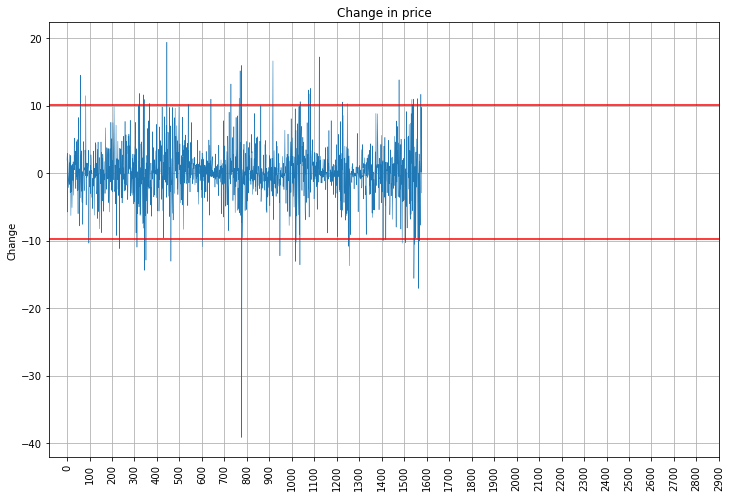

In [4]:
fig, ax1 = plt.subplots(figsize=(12,8))
graph = sns.lineplot(data = crypto, x=crypto.index, y='Change',markers = True,linewidth = 0.5)
ax1.set(title='Change in price')
plt.xticks(np.arange(0,3000,100),rotation = 90)
graph.axhline(tolerance_upper, color = "red")
graph.axhline(tolerance_lower, color = "red")
plt.grid()
plt.show()

In [5]:
unusual_dates_high = {}
unusual_dates_low = {}

for i in crypto["Change"]:
    if i>0 and i>tolerance_upper:
        unusual_dates_high[crypto["Datetime"][crypto.Change == i ].values[0]] = i
    elif i<0 and i<tolerance_lower:
        unusual_dates_low[crypto["Datetime"][crypto.Change == i ].values[0]] = i

print("Dates that have high price increase")
print(unusual_dates_high)
print("\n")
print("Dates that have large drop in price")
print(unusual_dates_low)

Dates that have high price increase
{'2022-02-28': 14.536, '2022-02-04': 11.478, '2021-06-09': 11.822, '2021-05-24': 11.608, '2021-05-20': 10.925, '2021-04-26': 10.328, '2021-02-08': 19.412, '2020-11-05': 10.19, '2020-07-27': 10.975, '2020-04-29': 13.221, '2020-03-23': 11.111, '2020-03-19': 15.166, '2020-03-13': 15.972, '2019-10-25': 16.645, '2019-06-26': 10.601, '2019-05-19': 12.329, '2019-05-13': 11.759, '2019-05-11': 12.584, '2019-04-02': 17.23, '2018-12-20': 10.545, '2018-11-28': 10.32, '2018-04-12': 13.834, '2018-02-14': 10.93, '2018-02-12': 10.143, '2018-02-06': 10.979, '2018-01-20': 11.052, '2018-01-05': 11.691}


Dates that have large drop in price
{'2022-01-21': -10.375, '2021-09-07': -11.191, '2021-06-21': -10.972, '2021-05-19': -14.401, '2021-05-12': -12.894, '2021-01-21': -13.053, '2020-09-03': -10.903, '2020-03-12': -39.182, '2019-09-24': -12.252, '2019-07-16': -13.087, '2019-07-14': -10.244, '2019-06-27': -13.586, '2018-11-24': -10.845, '2018-11-19': -13.72, '2018-06-22':

In [6]:
# unusual_increase_df = pd.DataFrame.from_dict(data = unusual_dates_high,orient = "index", columns = ["Change"])
# unusual_decrease_df = pd.DataFrame.from_dict(data = unusual_dates_low,orient = "index", columns = ["Change"])
# plot_unusual = pd.concat([unusual_increase_df,unusual_decrease_df])
# plot_unusual.plot(kind = "barh")

# Sentiment Analysis of Tweets from Influencers

This section we extract tweets and process them

## Scrap Tweets from all excel file in a folder

1) Change your directory to the folder with all the excel files

2) Tweet columns scrapped are
    
    -Datetime
    
    -Tweet ID
    
    -Text
    
    -Username

In [7]:
# assign directory
directory = r"C:\Users\rache\Singapore Management University\Social Analytics - General\Data\Twitter Data\Level 0 Tweets\Institution_Influencer_tweet\cz_binance_tweet"
os.chdir(directory)

df_consolidated = pd.DataFrame()

# iterate over files in that directory
for filename in os.listdir(r"C:\Users\rache\Singapore Management University\Social Analytics - General\Data\Twitter Data\Level 0 Tweets\Institution_Influencer_tweet\cz_binance_tweet"):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        df = pd.read_csv(filename)
        df_consolidated = df_consolidated.append(df,ignore_index = True)

df_consolidated

C:\Users\rache\AppData\Local\Temp\ipykernel_23144\2563161810.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated = df_consolidated.append(df,ignore_index = True)
C:\Users\rache\AppData\Local\Temp\ipykernel_23144\2563161810.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated = df_consolidated.append(df,ignore_index = True)
C:\Users\rache\AppData\Local\Temp\ipykernel_23144\2563161810.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated = df_consolidated.append(df,ignore_index = True)
C:\Users\rache\AppData\Local\Temp\ipykernel_23144\2563161810.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

,Unnamed: 0,Datetime,Tweet Id,Text,Username
0,0,2019-01-30 06:08:04+00:00,1090491816888029186,The amount of security efforts going on in an ...,cz_binance
1,1,2019-01-30 00:51:23+00:00,1090412121895006208,Milestone #safu https://t.co/EV3viRuMX0,cz_binance
2,2,2019-01-28 16:29:21+00:00,1089923394219327493,"Due to overwhelming demands, Tron team generou...",cz_binance
3,3,2019-01-27 07:21:57+00:00,1089423249845305344,@Binance_DEX Binance DEX will support hardware...,cz_binance
4,4,2019-01-27 06:46:01+00:00,1089414206955245568,"Another busy Sunday, relaunching Launchpad. L...",cz_binance
...,...,...,...,...,...
2600,406,2022-04-02 10:14:36+00:00,1510199008148475905,The Builder: How @Binance Product Lead Mayur K...,cz_binance
2601,407,2022-04-02 01:04:29+00:00,1510060569365295110,Zoom out. You don’t just live in a city or cou...,cz_binance
2602,408,2022-04-01 19:10:44+00:00,1509971544683991056,"Might buy some fiat today, looks like a decent...",cz_binance
2603,409,2022-04-01 14:59:17+00:00,1509908262694576135,"@PeterSchiff Peter may be Satoshi, because he ...",cz_binance


Change datetime column to string type so we can clean it

In [8]:
df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"] = df_consolidated["Datetime"].str[:10]
df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"]

0       2019-01-30
1       2019-01-30
2       2019-01-28
3       2019-01-27
4       2019-01-27
           ...    
2600    2022-04-02
2601    2022-04-02
2602    2022-04-01
2603    2022-04-01
2604    2022-04-01
Name: Datetime, Length: 2605, dtype: string

### this section we explore whether prices with high increase, have positive sentiments

In [9]:
print("Dates that have high price increase")
print(unusual_dates_high)

Dates that have high price increase
{'2022-02-28': 14.536, '2022-02-04': 11.478, '2021-06-09': 11.822, '2021-05-24': 11.608, '2021-05-20': 10.925, '2021-04-26': 10.328, '2021-02-08': 19.412, '2020-11-05': 10.19, '2020-07-27': 10.975, '2020-04-29': 13.221, '2020-03-23': 11.111, '2020-03-19': 15.166, '2020-03-13': 15.972, '2019-10-25': 16.645, '2019-06-26': 10.601, '2019-05-19': 12.329, '2019-05-13': 11.759, '2019-05-11': 12.584, '2019-04-02': 17.23, '2018-12-20': 10.545, '2018-11-28': 10.32, '2018-04-12': 13.834, '2018-02-14': 10.93, '2018-02-12': 10.143, '2018-02-06': 10.979, '2018-01-20': 11.052, '2018-01-05': 11.691}


In [10]:
res = []
for i in unusual_dates_high.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_high = df_consolidated.loc[res]


## Tweets pre-processing

We remove all @ and hyperlinks using regex, but keep hashtags as they can provide insights

In [11]:
df_high

,Unnamed: 0,Datetime,Tweet Id,Text,Username
2336,142,2022-02-04,1489630973658607625,Human to human communication is painfully slow.,cz_binance
2337,143,2022-02-04,1489603875560587266,What little product improvements do you sugges...,cz_binance
2338,144,2022-02-04,1489545612718579715,There is a massive Phishing scam via SMS with ...,cz_binance
2339,145,2022-02-04,1489458510312005639,Advertising is good. Let's do it responsibly.\...,cz_binance
1672,875,2021-06-09,1402678833191342084,We can remove the red button for El Salvador u...,cz_binance
...,...,...,...,...,...
194,194,2019-05-11,1127237352256983040,@cryptomanran dude... don't know how to reply ...,cz_binance
195,195,2019-05-11,1127201545097867264,@CryptoVanessa @binance We are aiming for earl...,cz_binance
153,153,2019-04-02,1113104721286316032,". @binance meetup in St Petersburg, Russia htt...",cz_binance
154,154,2019-04-02,1112976613514174464,when you short $BTC https://t.co/UQW2x0Y5NH,cz_binance


In [12]:
all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_high["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])

all_tweets

['human to human communication is painfully slow.',
 'what little product improvements do you suggest us to make? the more detailed, the better.',
 'there is a massive phishing scam via sms with a link to cancel withdrawals. it leads to a phishing website to harvest your credential as in the screenshot below.  never click on links from sms!   always go to ',
 "advertising is good. let's do it responsibly.   » super bowl 2022 is being called 'crypto bowl' as upstart finance firms spend millions on t.v. ads | fortune ",
 'we can remove the red button for el salvador users now, right? as selling (into fiat) is no longer necessary. they can use #bitcoin directly, the way it should be.  half (lame) joke, half serious, nfa.',
 '#bitcoin -&gt; better money -&gt; bigger economies -&gt;  wealthier citizens -&gt; more (globally) influential governments -&gt; stronger countries.  adopting #bitcoin is patriotic.',
 'sovereign individuals use #bitcoin. sovereign nations use #bitcoin.',
 'i was orig

Next we filter all tweets using keywords in the filter_crypto list, we are only interested to see tweets related to cryptocurrencies and its related subjects

In [13]:
filter_crypto = ["eth","bitcoin","coindesk"," ethereum","crypto","cryptography","cryptocurrency","nfts","nft's","coin","doge","dogecoin","stablecoin","fiat","token","mine","mining","miners","altcoin","blockchain","hodl","wallet","wallets"]
crypto_tweets = []
# as long as one of the filter words are in the tweets, we capture them
for tweets in all_tweets:
    for i in filter_crypto:
        if i in tweets:
            crypto_tweets.append(tweets)
            break
            
print("From {} number of tweets, this influencer has tweeted {} related to crypto".format(len(all_tweets),len(crypto_tweets)))

From 64 number of tweets, this influencer has tweeted 22 related to crypto


In [14]:
crypto_tweets

["advertising is good. let's do it responsibly.   » super bowl 2022 is being called 'crypto bowl' as upstart finance firms spend millions on t.v. ads | fortune ",
 'we can remove the red button for el salvador users now, right? as selling (into fiat) is no longer necessary. they can use #bitcoin directly, the way it should be.  half (lame) joke, half serious, nfa.',
 '#bitcoin -&gt; better money -&gt; bigger economies -&gt;  wealthier citizens -&gt; more (globally) influential governments -&gt; stronger countries.  adopting #bitcoin is patriotic.',
 'sovereign individuals use #bitcoin. sovereign nations use #bitcoin.',
 'welcome to #crypto.   » hedge fund billionaire ray dalio: ‘i have some bitcoin’ - coindesk ',
 'for most people, i strongly recommend a hodl strategy rather than an active trading strategy to try to catch the elusive opportunities like below.  not financial advice.',
 'don’t be a bear in crypto.',
 "today marks the day that soon after, if you are a corporate treasury a

Next, we tokenize the processed tweets, to conduct our sentiment analysis. 

In [15]:
def is_valid_token(token):
    # keep hashtag, but not user mentions, i've retained the code for keeping user mentions
    # if ((token.startswith('#') or token.startswith('@')) and len(token) > 2):
    if (token.startswith('#') and len(token) > 2):
        return True
    # if a token contains at least two consective English letters, we assume it's a word
    if re.match(r'.*[a-z]{2,}.*', token):
        return True
    return False

tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in crypto_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

[['advertising',
  'is',
  'good',
  "let's",
  'do',
  'it',
  'responsibly',
  'super',
  'bowl',
  'is',
  'being',
  'called',
  'crypto',
  'bowl',
  'as',
  'upstart',
  'finance',
  'firms',
  'spend',
  'millions',
  'on',
  'ads',
  'fortune'],
 ['we',
  'can',
  'remove',
  'the',
  'red',
  'button',
  'for',
  'el',
  'salvador',
  'users',
  'now',
  'right',
  'as',
  'selling',
  'into',
  'fiat',
  'is',
  'no',
  'longer',
  'necessary',
  'they',
  'can',
  'use',
  '#bitcoin',
  'directly',
  'the',
  'way',
  'it',
  'should',
  'be',
  'half',
  'lame',
  'joke',
  'half',
  'serious',
  'nfa'],
 ['#bitcoin',
  'better',
  'money',
  'bigger',
  'economies',
  'wealthier',
  'citizens',
  'more',
  'globally',
  'influential',
  'governments',
  'stronger',
  'countries',
  'adopting',
  '#bitcoin',
  'is',
  'patriotic'],
 ['sovereign',
  'individuals',
  'use',
  '#bitcoin',
  'sovereign',
  'nations',
  'use',
  '#bitcoin'],
 ['welcome',
  'to',
  '#crypto',
  '

In [16]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# # stemming
# stemmer = PorterStemmer()
# # only perform stemming on tokens not starting with # or @
# crypto_tokens = [[token if token.startswith('#') or token.startswith('@') else stemmer.stem(token) for token in doc] for doc in crypto_tokens]

# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]

In [17]:
crypto_tokens

[['advertising',
  'good',
  "let's",
  'responsibly',
  'super',
  'bowl',
  'called',
  'crypto',
  'bowl',
  'upstart',
  'finance',
  'firms',
  'spend',
  'millions',
  'ads',
  'fortune'],
 ['remove',
  'red',
  'button',
  'el',
  'salvador',
  'users',
  'right',
  'selling',
  'fiat',
  'longer',
  'necessary',
  'use',
  '#bitcoin',
  'directly',
  'way',
  'half',
  'lame',
  'joke',
  'half',
  'serious',
  'nfa'],
 ['#bitcoin',
  'better',
  'money',
  'bigger',
  'economies',
  'wealthier',
  'citizens',
  'globally',
  'influential',
  'governments',
  'stronger',
  'countries',
  'adopting',
  '#bitcoin',
  'patriotic'],
 ['sovereign',
  'individuals',
  'use',
  '#bitcoin',
  'sovereign',
  'nations',
  'use',
  '#bitcoin'],
 ['welcome',
  '#crypto',
  'hedge',
  'fund',
  'billionaire',
  'ray',
  'dalio',
  'bitcoin',
  'coindesk'],
 ['people',
  'strongly',
  'recommend',
  'hodl',
  'strategy',
  'rather',
  'active',
  'trading',
  'strategy',
  'try',
  'catch',


In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def print_sentiment(model, doc):
    '''
    model: a sentiment model
    doc: a string representing a document
    '''
    print("Crypto Tweets Sentiments from this Influencer")
    ps = model.polarity_scores(doc)
    print('-' * 20)
    print('Positive:', '%.1f%%' % (ps['pos'] * 100))
    print('Negative:', '%.1f%%' % (ps['neg'] * 100))
    print('Neutral:', '%.1f%%' % (ps['neu'] * 100))
    print('Compound score (-1 to 1):', ps['compound'])
    print('-' * 20 + '\n')

# loading a pre-trained polarity model
model = SentimentIntensityAnalyzer()

In [19]:
def count_sentiment_hike(model, doc):
    ps = model.polarity_scores(doc)
    c = ps['compound']
    
    falseneg = 0
    truepos = 0
    neu = 0
    if c < 0:
        falseneg +=1
    elif c > 0:
        truepos += 1
    else:
        neu += 1
        
    print(falseneg, truepos)

Here we explore the overall sentiments of the tweets from this influencer during periods of high increase of prices in bitcoin

In [20]:
total_sentiments = ""

for i in crypto_tokens:
    total_sentiments = total_sentiments + " ".join(i) + " "
    
print_sentiment(model, total_sentiments)

Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 22.4%
Negative: 4.7%
Neutral: 72.9%
Compound score (-1 to 1): 0.9931
--------------------



Here we explore the sentiments of the individual tweets from this influencer

In [21]:
for i in range(len(crypto_tokens)):
    count_sentiment_hike(model," ".join(crypto_tokens[i]))
    

0 1
1 0
0 1
0 0
0 1
0 1
1 0
0 1
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1


## This section, we explore the sentiments of tweets during days of large decrease in prices

In [22]:
res = []
for i in unusual_dates_low.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_low = df_consolidated.loc[res]

all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_low["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])
    
filter_crypto = ["eth","bitcoin","coindesk"," ethereum","crypto","cryptocurrency","nfts","nft's","coin","doge","dogecoin","stablecoin","fiat","token","mine","mining","miners","altcoin","blockchain","hodl","wallet","wallets"]
crypto_tweets = []
# as long as one of the filter words are in the tweets, we capture them
for tweets in all_tweets:
    for i in filter_crypto:
        if i in tweets:
            crypto_tweets.append(tweets)
            break
            
tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in crypto_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]

total_sentiments = ""

for i in crypto_tokens:
    total_sentiments = total_sentiments + " ".join(i) + " "
    
print_sentiment(model, total_sentiments)



Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 17.0%
Negative: 17.3%
Neutral: 65.7%
Compound score (-1 to 1): -0.1027
--------------------



In [23]:
def count_sentiment_dip(model, doc):
    ps = model.polarity_scores(doc)
    c = ps['compound']
    
    trueneg = 0
    falsepos = 0
    neu = 0
    if c < 0:
        trueneg +=1
    elif c > 0:
        falsepos += 1
    else:
        neu += 1
        
    print(falsepos, trueneg)

In [24]:
for i in range(len(crypto_tokens)):
    count_sentiment_dip(model," ".join(crypto_tokens[i]))
    
    

1 0
1 0
1 0
0 0
1 0
0 1
0 0
0 1
